# Holt-Winters-Additive Dampened and Exponential Smoothing

In [25]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import statsmodels.api as sm
import pickle
from sklearn.metrics import mean_squared_error
from datetime import datetime
from matplotlib import pyplot as plt
from matplotlib.dates import date2num
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
%matplotlib inline
import json
plt.close("all")

import sys
!{sys.executable} -m pip install statsmodels

euroData = pd.read_csv("data\euro_countries_filled.csv")
with open("data/iso_country_codes.json", "r") as read_file:
    countryCodes = json.load(read_file)

warnings.filterwarnings("ignore")

## Creating Datasets

In [2]:
def country_set(iso_code, smoothed = False, beg_date='2020-01-01', end_date=euroData["date"].iloc[-1]):
    """For specific country.
    :param iso_code: The county's ISO-code (3 letters)
    :param smoothed: True->Uses new_cases_smoothed_per_million as the source for new cases (7-day average)
                     False->Uses raw data from new_cases_per_million
    :param beg_date: beginning of the dataset
    :param end_date: end of the dataset   
    """
    if (smoothed):
        df = euroData[euroData.iso_code==iso_code].groupby("date")["new_cases_smoothed_per_million"].sum().reset_index(name = "new_cases_per_million")
    else:
        df = euroData[euroData.iso_code==iso_code].groupby("date")["new_cases_per_million"].sum().reset_index(name = "new_cases_per_million")
        
    df['date'] = pd.to_datetime(df['date'])
    # Set the date as index 
    df = df.set_index('date')
    # Select the proper time period for weekly aggreagation
    df = df[beg_date:end_date]
    return df

## Visualizing the data 

In [3]:
df_nor = country_set("NOR")
df_esp = country_set("ESP")
df_deu = country_set("DEU")

In [4]:
def Initial_plot(df, country_name):
    y = df['new_cases_per_million']
    fig, ax = plt.subplots(figsize=(20, 6))
    plt.title("Number of Daily New Cases of COVID-19 in " + country_name)
    ax.plot(y,marker='.', linestyle='-', linewidth=0.5, label='Daily')
    ax.plot(y.resample('W').mean(),marker='o', markersize=8, linestyle='-', label='Weakly Mean Resample')
    ax.set_ylabel('Daily New Cases of COVID-19 in '+country_name)
    ax.legend();

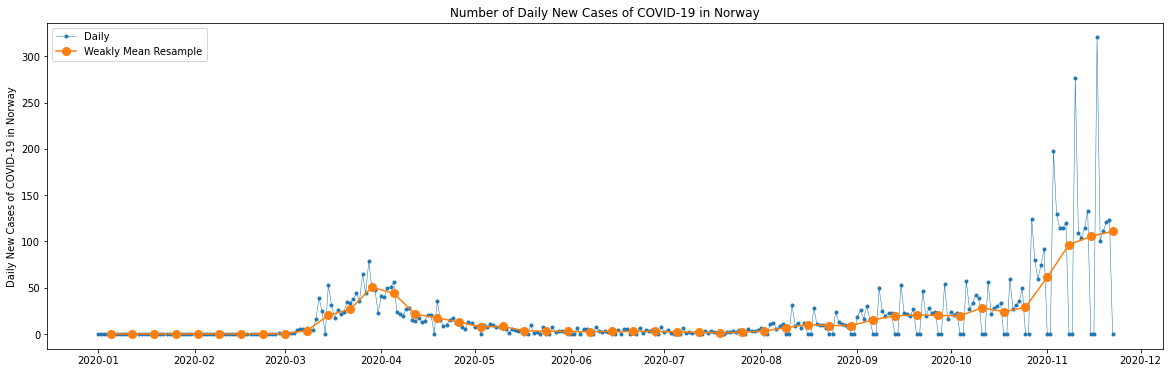

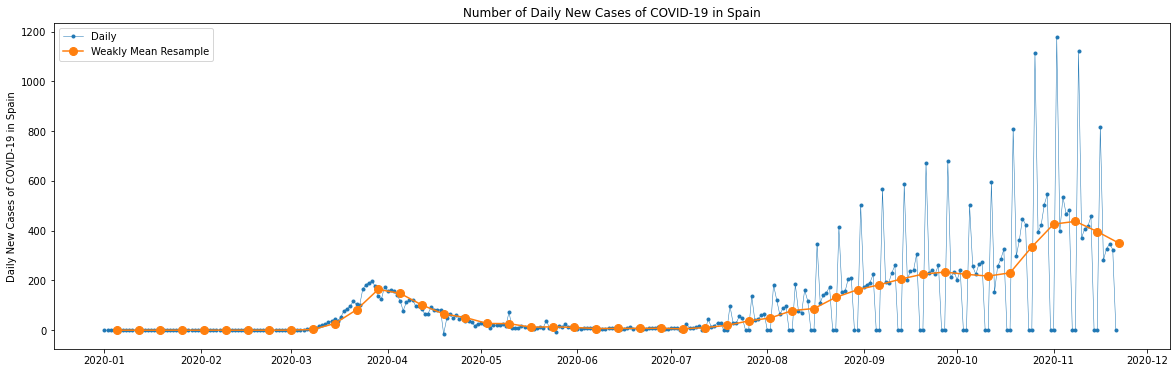

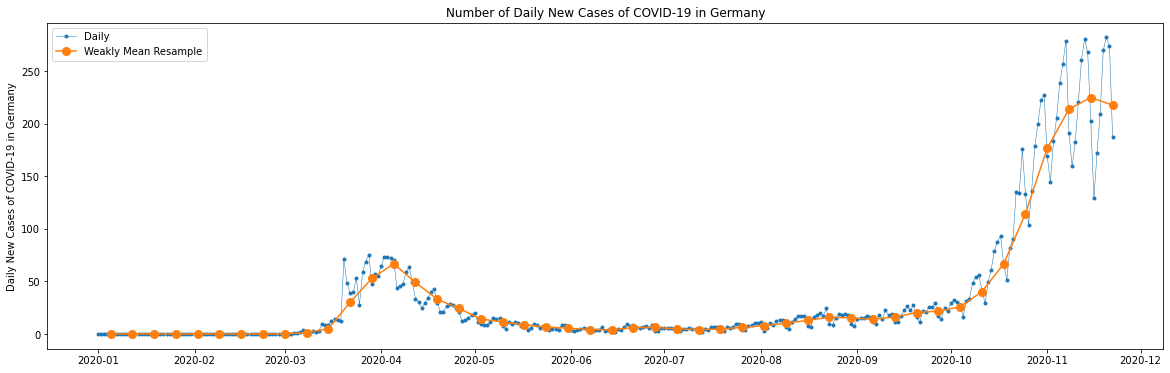

In [5]:
Initial_plot(df_nor, country_name = 'Norway')
Initial_plot(df_esp, country_name = 'Spain')
Initial_plot(df_deu, country_name = 'Germany')

### Decomposing the data

Into Trend, Season and Residual

In [6]:
def seasonal_decompose(y, country_name):
    """For specific country.
    :param y: dataseries
    :param country_name: for the heading  
    """
    decomposition = sm.tsa.seasonal_decompose(y, model='additive',extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,14)
    fig.suptitle("Decomposition of the Time Series of COVID-19 Cases in " + country_name, fontsize=16)
    plt.show()


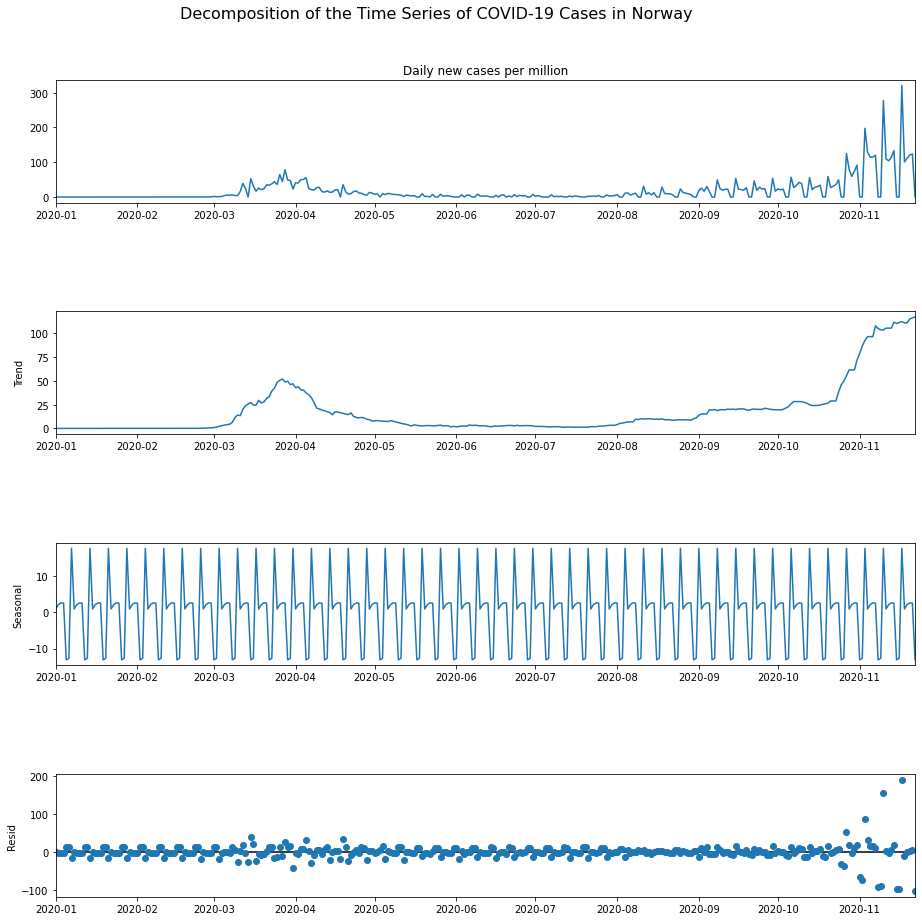

In [7]:
y_nor = df_nor['new_cases_per_million'].rename("Daily new cases per million")
seasonal_decompose(y_nor, country_name ='Norway')

## Creating Forecasts

In [8]:
def country_forecasts(iso_cd = None, smoothed = False, \
                      s_date='2020-01-01',train_e_date='2020-10-31', test_s_date = '2020-11-01', e_date='2020-11-07'):
    """Creating forecasts for specific country.
    ES methods: Holt Linear, Holt-Winters-Additive and Holt-Winters-Additive Dampened
    
    :param iso_code: The county's ISO-code (3 letters)
    :param smoothed: True->Uses new_cases_smoothed_per_million as the source for new cases (7-day average)
                     False->Uses raw data from new_cases_per_million
    :param s_date: beginning of the entire dataset
    :param train_e_date: ending of training part of the set
    :param test_s_date: start of test part of set
    :param e_date: end of the entire dataset
    
    :return y: Pandas Series containing the actual reported data
    :return *method*_forecast: Pandas Series containing the forecast based on the given method
    :return results:Dataframe containing hyperparameters and error
    """
    df = country_set(smoothed=smoothed, iso_code=iso_cd, end_date=e_date)
    
    name = iso_cd
        
    y = df['new_cases_per_million'].rename('Actual Reported Data')
    y = y[s_date:]
    y_to_train = y[:train_e_date]
    
    # dataset to train
    y_to_test = y[test_s_date:] # last X months for test
    predict_date = len(y) - len(y_to_train) 
    
    #Holt Linear
    holt_lin_fit = Holt(y_to_train).fit(optimized=True)
    holt_lin_forecast = holt_lin_fit.forecast(predict_date).rename("Holt's Linear")
    mse_holt_lin = mean_squared_error(holt_lin_forecast, y_to_test)
    
    #Holt-Winters-Additive
    holtw_ad_fit = ExponentialSmoothing(y_to_train, seasonal_periods=7, trend='add', seasonal='add').fit(optimized=True)
    holtw_ad_forecast = holtw_ad_fit.forecast(predict_date).rename("Holt-Winter's Additive")
    mse_holtw_ad = mean_squared_error(holtw_ad_forecast, y_to_test)
    
    #Holt-Winters-Additive Dampened
    holtw_ad_damp_fit = ExponentialSmoothing(y_to_train, seasonal_periods = 7, trend='add', seasonal='add', damped=True).fit(optimized=True)
    holtw_ad_damp_forecast = holtw_ad_damp_fit.forecast(predict_date).rename("Holt-Winter's Additive+Damped")
    mse_holtw_ad_damp = mean_squared_error(holtw_ad_damp_forecast, y_to_test)
    
    params = ['smoothing_level', 'smoothing_trend', 'damping_trend', 'initial_level', 'initial_trend', 'smoothing_seasonal']
    results=pd.DataFrame(index=[r"Smooth. Lvl ($\alpha$)",r"Smooth. Trend ($\beta$)",r"Damp. Trend ($\phi$)",\
                                r"Initial Lvel ($l_0)$","Initial Trend ($b_0)$",r"Season Smoothing ($\gamma$)",\
                                "Mean Squared Error"] ,\
                         columns=["Holt's Linear","Holt-Winter's Additive","Holt-Winter's Additive + Damped"])
    results["Holt's Linear"] = [format(holt_lin_fit.params[p],".2f") for p in params] + [format(mse_holt_lin, ".2f")] 
    results["Holt-Winter's Additive"] = [format(holtw_ad_fit.params[p],".2f") for p in params] + [format(mse_holtw_ad, ".2f")]
    results["Holt-Winter's Additive + Damped"] = [format(holtw_ad_damp_fit.params[p],".2f") for p in params] + [format(mse_holtw_ad_damp, ".2f")]
    
    return y, holt_lin_forecast, holtw_ad_forecast, holtw_ad_damp_forecast, mse_holt_lin, mse_holtw_ad, mse_holtw_ad_damp, results
    

## Plotting Forecasts

In [9]:

def plot_methods(iso_code, smoothed=False, s_date='2020-01-01',train_e_date='2020-10-31',\
                 test_s_date = '2020-11-01', e_date='2020-11-07', plot_start = '2020-10-10'):
    """Plotting the different forecasting methods.
    ES methods: Holt Linear, Holt-Winters-Additive and Holt-Winters-Additive Dampened
    
    :param iso_code: The county's ISO-code (3 letters)
    :param smoothed: True->Uses new_cases_smoothed_per_million as the source for new cases (7-day average)
                     False->Uses raw data from new_cases_per_million
    :param s_date: beginning of the entire dataset
    :param train_e_date: ending of training part of the set
    :param test_s_date: start of test part of set
    :param e_date: end of the entire dataset
    :param plot_start: start of plot
    """
    y, holt_lin_forecast,\
    holtw_ad_forecast, \
    holtw_ad_damp_forecast, \
    mse_holt_lin, mse_holtw_ad, mse_holtw_ad_damp, \
    results = country_forecasts(iso_cd=iso_code, smoothed=smoothed, \
                                    s_date=s_date,train_e_date=train_e_date, test_s_date=test_s_date, e_date=e_date)
    smoothed_txt=""
    if (smoothed == True):
        smoothed_txt += " (Smoothed)"
        
    y.plot(marker='o', color='black', legend="Actual Number of Cases", figsize=(14, 7), xlim=(plot_start,e_date))
        
    holt_lin_forecast.plot(style='--', marker='o', color='red', legend=True, xlim=(plot_start,e_date))
    holtw_ad_forecast.plot(style='--', marker='o', color='green', legend=True, xlim=(plot_start,e_date))
    holtw_ad_damp_forecast.plot(style='--', marker='o', color='blue', legend=True, xlim=(plot_start,e_date))
        
    plt.title("Comparison of different Exponential Smoothing methods - "+ iso_code +smoothed_txt)
    plt.ylim(0, None)
    plt.axvspan(test_s_date, '2020-11-08' , alpha=0.1, color='grey' )
    plt.xlim(plot_start, '2020-11-08')
    plt.ylabel("Daily new COVID-19 cases per million")
    plt.xlabel("Date")
        
    display(results)


In [ ]:
#plot_methods('NOR', smoothed=True)

## Calculating the forecasting error

In [22]:

def forecast_error(smoothed=True, s_date='2020-01-01',train_e_date='2020-10-31',\
                 test_s_date = '2020-11-01', e_date='2020-11-07', plot_start = '2020-10-10'):
    
    """Printing error estimates for Holt-Winters-Additive Dampened
    :param smoothed: True->Uses new_cases_smoothed_per_million as the source for new cases (7-day average)
                     False->Uses raw data from new_cases_per_million
    :param s_date: beginning of the entire dataset
    :param e_date: end of the entire dataset
    :param plot_start: start of plot
    """
    
    iso_codes = euroData["iso_code"].unique()
    mse_holt_lin = 0
    mse_holtw_ad = 0 
    mse_holtw_ad_damp = 0
    
    for iso_code in iso_codes:
        y, holt_lin_forecast,\
        holtw_ad_forecast, \
        holtw_ad_damp_forecast, \
        mse_1, mse_2, mse_3, \
        results = country_forecasts(iso_cd=iso_code, smoothed=smoothed, \
                                    s_date=s_date,train_e_date=train_e_date, test_s_date=test_s_date, e_date=e_date)
        print('RMSE ', iso_code," = ", round(np.sqrt(mse_3),2))
        
        mse_holt_lin += mse_1
        mse_holtw_ad += mse_2
        mse_holtw_ad_damp+= mse_3
    
    print("RMSE TOTAL Holt-Winter's Additive + Damped = ", round(np.sqrt(mse_holtw_ad_damp/iso_codes.size), 2))
    

In [21]:
#forecast_error()

## Save as CSV-file 

In [23]:
def predictions_to_csv( iso_codes ):
    """Saves the Holt-Winters-Additive Dampened forecast of all countries in the array as a csv-file
    :param iso_codes: Array of the countries ISO-codes (3 letters)
    """
    df = pd.DataFrame()
    i = 0
    for iso_code in iso_codes:
        y, holt_lin_forecast,\
        holtw_ad_forecast, \
        holtw_ad_damp_forecast, \
        mse_holt_lin, mse_holtw_ad, mse_holtw_ad_damp, \
        results = country_forecasts(iso_cd=iso_code, smoothed=True)
        
        frame = {'Holt-Winter Additive + Damped ' + iso_code : holtw_ad_damp_forecast}
        if (i==0):
            df = pd.DataFrame(frame)
            i=1
        else:
            df['Holt-Winter Additive + Damped ' + iso_code ] = holtw_ad_damp_forecast.values
        df.to_csv("predictions\hw_predictions.csv")
    return df
    

In [24]:
#predictions_to_csv(['NOR', 'SWE', 'FIN', 'BEL'])